In [1]:
import pandas as pd
import requests
import numpy as np
import math 
import datetime

def get_value(x):
    if str(x).isdigit() and math.isnan(float(x))==False:
        x= int(x)/100

    else:
        pass
    return x

def assign_risk(row):
    if row.ZGZ_NR >=0.7425:
        risk= True
    else:
        risk = False
    return risk


def download_chebro_data(all_signals,columnas,nr_days):
    now = datetime.datetime.now().replace(minute=0, hour=0, second=0, microsecond=0)
    then = now - datetime.timedelta(days=nr_days)
    from_date= then.strftime('%Y-%m-%d-%H-%M')
    to_date= now.strftime('%Y-%m-%d-%H-%M')

    all_df=[]

    for signal in all_signals:

        url = "http://www.saihebro.com/saihebro/views/elements/graficas/ajax.php?url=/sedh/ajax_obtener_datos_numericos/"+ \
        "fecha_ini:"+from_date+"/fecha_fin:"+to_date+"/intervalo_hora:0/"+ \
        "_senal:"+signal+"&_=1612026927029"

        r = requests.get(url)
        df_list = pd.read_html(r.text)
        df = df_list[0].droplevel(level=0, axis=1)
        df.Fecha =df.Fecha.apply(lambda x: x.replace("\/", "/"))
        df.columns = ['fecha',signal]
        df[signal] = df[signal].apply(lambda x: get_value(x))
        df = df[:-1]
        all_df.append(df)
    
    df_zaragoza,df_novillas,df_tudela,df_tauste,df_grisen = all_df

    df = df_zaragoza.merge(df_novillas,on='fecha').merge(df_tudela,on='fecha').merge(df_tauste,on='fecha').merge(df_grisen,on='fecha')
    return df


def clean_data(df):
    # update columns names
    df.columns = ["time"] + columnas

    # set time format
    df['time'] = pd.to_datetime(df['time'])

    # sort values 
    df = df.sort_index(ascending=False).reset_index(drop=True)

    # as we are interested in hourly values we generate a df_time with datetime range of interest and merge it with the orginal df
    date_range = pd.date_range(df.time.iloc[0],df.time.iloc[-1],freq='h')
    df_time = pd.DataFrame(date_range,columns =["time"])
    df = pd.merge(df_time,df, on="time",how="left")

    # drop empty rows
    df = df.dropna(subset=columnas)
    return df

def feature_engineering(df):
    # assign risk type
    df["RIESGO"] = df.apply(lambda row: assign_risk(row), axis=1)

    # lag feautres for the most important features
    for i in range(1,3):
        df['NOVILLAS_NR-%d'%i] = df['NOVILLAS_NR'].shift(i)
        df['TUDELA_NR-%d'%i] = df['TUDELA_NR'].shift(i)
        df['ZGZ_NR-%d'%i] = df['ZGZ_NR'].shift(i)

    # time feature
    df["month"] = df.time.apply( lambda m: m.month)

    # one hot encodeing for time feature
    df_onehot = df.copy()
    df_onehot = pd.get_dummies(df_onehot, columns=['month'], prefix = ['month'])

    df_onehot.head()

    # targets
    df_onehot["pred_24h"] = df_onehot.ZGZ_NR.shift(-24)
    df_onehot["pred_48h"] = df_onehot.ZGZ_NR.shift(-48)
    df_onehot["pred_72h"] = df_onehot.ZGZ_NR.shift(-72)
    
    return df_onehot  


"""
A011Z17NRIO1 -- nivel rio ebro zaragoza
A285E01NRIO1 -- novillas
A284Z01NRIO1 -- tudela
A260E17NRIO1 -- tauste
A286Z01NRIO1 -- alagon ( no tiene datos)
A087Z17NRIO1 -- jalon en grisen
"""

all_signals = ["A011Z17NRIO1","A285E01NRIO1","A284Z01NRIO1", "A260E17NRIO1","A087Z17NRIO1"]
columnas= ["ZGZ_NR","NOVILLAS_NR","TUDELA_NR","TAUSTE_NR","GRISEN_NR"]
    
""" STEP 1: DOWNLOAD DATA FROM SAIH EBRO """
df_raw = download_chebro_data(all_signals,columnas,90)

""" STEP 2: DATA CLEANING """
df_clean = clean_data(df_raw)

""" STEP 3: FEATURE ENGINEERING """
df = feature_engineering(df_clean)

""" STEP 3: SAVE DATA FOR ML MODEL"""
df.to_csv("data_chebro.csv")

C:\Users\dorota.nn\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dorota.nn\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\dorota.nn\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


<AxesSubplot:>

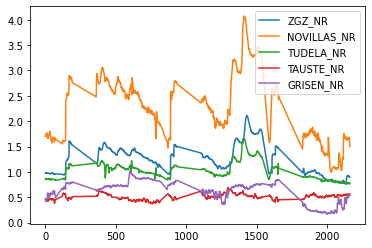

In [2]:
df[columnas].plot()